In [1]:
# builtins
import sys
import os
import time
import logging
from datetime import timedelta
from logging.config import dictConfig
import numpy as np
import datetime
import pathlib
import pandas as pd
import joblib
from dask.distributed import Client
import optuna
import distributed
from optuna.integration.dask import DaskStorage
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error

from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import joblib

# externals|
import xarray as xr

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import lightgbm as lgb
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# locals
from downscaleml.core.dataset import ERA5Dataset, NetCDFDataset, EoDataset

from downscaleml.main.config_reanalysis_dev import (ERA5_PATH, OBS_PATH, DEM_PATH, MODEL_PATH, TARGET_PATH, 
                                     NET, ERA5_PLEVELS, ERA5_PREDICTORS, PREDICTAND,
                                     CALIB_PERIOD, VALID_PERIOD, DOY, NORM,
                                     OVERWRITE, DEM, DEM_FEATURES, STRATIFY, WET_DAY_THRESHOLD,
                                     VALID_SIZE, start_year, end_year, CHUNKS)

#from downscaleml.main.inputoutput import ()

from downscaleml.core.constants import (ERA5_P_VARIABLES, ERA5_P_VARIABLES_SHORTCUT, ERA5_P_VARIABLE_NAME,
                                        ERA5_S_VARIABLES, ERA5_S_VARIABLES_SHORTCUT, ERA5_S_VARIABLE_NAME,
                                        ERA5_VARIABLES, ERA5_VARIABLE_NAMES, ERA5_PRESSURE_LEVELS,
                                        PREDICTANDS, ERA5_P_VARIABLES, ERA5_S_VARIABLES)

from downscaleml.core.utils import NAMING_Model, normalize, search_files, LogConfig
from downscaleml.core.logging import log_conf
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
# module level logger
LOGGER = logging.getLogger(__name__)

def stacker(xarray_dataset):
    # stack along the lat and lon dimensions
    stacked = xarray_dataset.stack(spatial=('y', 'x'))
    dask_arr = stacked.to_array().data
    xarray_dataset = dask_arr.T
    LogConfig.init_log('Shape is in (spatial, time, variables):{}'.format(xarray_dataset.shape))
    return xarray_dataset

def doy_encoding(X, y=None, doy=False):

    # whether to include the day of the year as predictor variable
    if doy:
        # add doy to set of predictor variables
        LOGGER.info('Adding day of the year to predictor variables ...')
        X = X.assign(EoDataset.encode_doys(X, chunks=X.chunks))

    return X

def calculate_statistics_to_dataset(first_chunk, dim='time'):
    # Dictionary to hold new DataArrays for each statistic
    new_data_vars = {}

    # Iterate over each data variable in the dataset
    for var_name, data_array in first_chunk.data_vars.items():
        # Calculate the desired statistics over the specified dimension
        percentiles = data_array.quantile([0.10, 0.90], dim=dim)
        #median = data_array.median(dim=dim)
        std_val = data_array.std(dim=dim)
        mean_val = data_array.mean(dim=dim)

        # Select the 10th and 90th percentiles and drop the 'quantile' dimension to avoid conflict
        percentile_10 = percentiles.sel(quantile=0.10).drop_vars('quantile')
        percentile_90 = percentiles.sel(quantile=0.90).drop_vars('quantile')

        # Create new variables with the statistics, appending the variable name with the statistic
        new_data_vars[f"{var_name}_10th_percentile"] = percentile_10
        new_data_vars[f"{var_name}_90th_percentile"] = percentile_90
        #new_data_vars[f"{var_name}_median"] = median
        new_data_vars[f"{var_name}_std"] = std_val
        new_data_vars[f"{var_name}_mean"] = mean_val

    # Create a new xarray dataset with the statistics
    stats_dataset = xr.Dataset(new_data_vars)

    return stats_dataset

def silhouette_analysiss(data, max_k=10):
    silhouette_scores = []

    for k in range(2, max_k+1):  # Start from 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)

    # Plot the Silhouette scores
    plt.plot(range(2, max_k+1), silhouette_scores, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.savefig("cluster.png")
    #plt.show()

def find_optimal_clusterss(data, max_k=10):
    wcss = []  # List to store the within-cluster sum of squares for each k

    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)  # Inertia is the sum of squared distances to cluster centers

    # Plot the Elbow graph
    plt.plot(range(1, max_k+1), wcss, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.title('Elbow Method for Optimal k')
    plt.savefig("elbow.png")
    #plt.show()

def silhouette_analysis(data, max_k=10):
    silhouette_scores = []
    
    for k in range(2, max_k + 1):  # Start from 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)

    # Plot the Silhouette scores
    plt.plot(range(2, max_k + 1), silhouette_scores, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.savefig("cluster.png")
    
    # Find the optimal k based on the highest Silhouette Score
    optimal_k_silhouette = silhouette_scores.index(max(silhouette_scores)) + 2  # Add 2 since index starts at 0 for k=2
    return silhouette_scores, optimal_k_silhouette

def find_optimal_clusters(data, max_k=10):
    wcss = []

    for k in range(2, max_k + 1):  # Start from k=2 to match silhouette analysis
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow graph
    plt.plot(range(2, max_k + 1), wcss, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.title('Elbow Method for Optimal k')
    plt.savefig("elbow.png")
    
    return wcss, None  # Return full WCSS list


def apply_kmeans(data, n_clusters):
    """
    Applies KMeans clustering to the data and returns the cluster labels.
    
    Parameters:
    data (array-like): The input data to cluster.
    n_clusters (int): The number of clusters to form, determined dynamically.
    
    Returns:
    array: The cluster labels for each data point.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    return cluster_labels

def select_optimal_k(silhouette_scores, wcss_scores):
    """
    Selects the optimal number of clusters by finding the point where the variance 
    between silhouette scores and WCSS scores is highest.
    
    Parameters:
    - silhouette_scores: List of silhouette scores for different k values (higher is better)
    - wcss_scores: List of WCSS (within-cluster sum of squares) values for different k values (lower is better)
    
    Returns:
    - optimal_k: The optimal number of clusters where variance between silhouette and WCSS is highest
    """
    
    # Ensure both score lists have the same length
    if len(silhouette_scores) != len(wcss_scores):
        raise ValueError("Silhouette scores and WCSS scores must have the same length")

    # Infer the k_range based on the length of the input lists
    k_range = list(range(2, 2 + len(silhouette_scores)))

    # Convert lists to numpy arrays for mathematical operations
    silhouette_scores = np.array(silhouette_scores)
    wcss_scores = np.array(wcss_scores)

    # Normalize the Silhouette scores (higher is better)
    norm_silhouette = (silhouette_scores - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))

    # Invert and normalize WCSS scores (lower is better, so we invert the values)
    norm_wcss = (np.max(wcss_scores) - wcss_scores) / (np.max(wcss_scores) - np.min(wcss_scores))

    # Calculate the variance (absolute difference) between the normalized Silhouette and WCSS scores
    variance = np.abs(norm_silhouette - norm_wcss)

    # Find the k value where the variance is highest
    optimal_k_index = np.argmax(variance)
    optimal_k = k_range[optimal_k_index] + 7

    return optimal_k


# Create clustered map
def create_clustered_map(cluster_labels, statistics_dataset):
    """
    Reshapes the cluster labels into the shape of the statistics dataset
    and returns a DataArray for plotting.
    
    Parameters:
    cluster_labels (array): Cluster labels from KMeans.
    statistics_dataset (xarray.Dataset): Dataset containing coordinates for reshaping.
    
    Returns:
    xarray.DataArray: The reshaped and plotted cluster map.
    """
    clustered_map = cluster_labels.reshape(statistics_dataset.sizes['y'], statistics_dataset.sizes['x'])
    cluster_map = xr.DataArray(clustered_map, coords=[statistics_dataset['y'], statistics_dataset['x']], dims=['y', 'x'])
    cluster_map.plot()
    return cluster_map

def full_clustering_workflow(statistics_dataset, data, max_k=10):
    """
    Runs the full workflow to perform clustering and return a clustered map.
    
    Parameters:
    statistics_dataset (xarray.Dataset): Dataset containing the statistics and coordinates.
    data (array-like): The input data to be clustered.
    max_k (int): Maximum number of clusters to consider.
    
    Returns:
    xarray.DataArray: The final clustered map for plotting.
    """
    # Step 1: Perform Silhouette and Elbow analysis
    silhouette_scores, _ = silhouette_analysis(data, max_k=max_k)  # Full silhouette scores list
    wcss, _ = find_optimal_clusters(data, max_k=max_k)  # Full WCSS scores list

    # Step 2: Select optimal k by comparing full Silhouette and WCSS scores
    optimal_k = select_optimal_k(silhouette_scores, wcss)
    LogConfig.init_log(f"Final Selected Optimal k: {optimal_k}")    

    # Step 3: Apply KMeans with the dynamically determined optimal k
    cluster_labels = apply_kmeans(data, n_clusters=optimal_k)

    # Step 4: Reshape cluster labels and plot the clustered map
    clustered_map = create_clustered_map(cluster_labels, statistics_dataset)

    return clustered_map


def compute_summary_stats(ds, temp_threshold=303.15):
    """
    Compute summary statistics for DEM, slope, aspect, and 2m_temperature, reducing over time.
    
    Parameters:
    ds (xarray.Dataset): Input dataset with variables 'dem', 'slope', 'aspect', and '2m_temperature'.
    temp_threshold (float): Threshold to compute extreme temperature frequency (default is 30°C).
    
    Returns:
    xarray.Dataset: A new dataset with computed summary statistics.
    """
    
    # Compute temperature-related metrics
    temperature = ds['t2m']
    
    temp_max = temperature.max(dim='time')
    temp_min = temperature.min(dim='time')
    temp_range = temp_max - temp_min
    # Quantile calculation with renaming and selecting the scalar value
    temp_95th = temperature.quantile(0.95, dim='time').squeeze(drop=True).rename('temp_95th')
    temp_5th = temperature.quantile(0.05, dim='time').squeeze(drop=True).rename('temp_5th')
    temp_extreme_freq = (temperature > temp_threshold).sum(dim='time')
    
    # DEM metrics
    dem = ds['elevation']
    dem_mean = dem.mean(dim='time')
    dem_max = dem.max(dim='time')
    dem_min = dem.min(dim='time')
    dem_range = dem_max - dem_min
    dem_variance = dem.var(dim='time')
    
    # Combine all the computed metrics into a list of datasets
    stats_list = [
        xr.Dataset({'temp_max': temp_max}),
        xr.Dataset({'temp_min': temp_min}),
        xr.Dataset({'temp_range': temp_range}),
        xr.Dataset({'temp_95th': temp_95th}),
        xr.Dataset({'temp_5th': temp_5th}),
        xr.Dataset({'temp_extreme_freq': temp_extreme_freq}),
        xr.Dataset({'dem_mean': dem_mean}),
        xr.Dataset({'dem_max': dem_max}),
        xr.Dataset({'dem_min': dem_min}),
        xr.Dataset({'dem_range': dem_range}),
        xr.Dataset({'dem_variance': dem_variance})
    ]
    
    # Merge all datasets, ignoring conflicts with 'compat=override'
    summary_stats = xr.merge(stats_list, compat='override')
    
    return summary_stats

# Elbow Method for WCSS (Inertia)
def find_wcss(data, max_k=10):
    wcss = []

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    return wcss

def silhouette(data, max_k=10):
    silhouette_scores = []

    for k in range(2, max_k + 1):  # Start from 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)

    return silhouette_scores

def plot_silhouette_vs_wcss(data, max_k=10):
    silhouette_scores = silhouette(data, max_k)
    wcss = find_wcss(data, max_k)

    # Create figure and axis
    fig, ax1 = plt.subplots()

    # Plot Silhouette Scores on the left y-axis
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Silhouette Score', color='tab:blue')
    ax1.plot(range(2, max_k + 1), silhouette_scores, 'bx-', label='Silhouette Score', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a twin axis for the WCSS plot
    ax2 = ax1.twinx()
    ax2.set_ylabel('WCSS (Inertia)', color='tab:red')
    ax2.plot(range(1, max_k + 1), wcss, 'rx-', label='WCSS (Inertia)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Add title and show the plot
    plt.title('Silhouette Score vs WCSS (Inertia) for Optimal k')
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig("silhoutte_vs_variance.png")

# Example of how to run the plot
# Assuming you have your data matrix 'data'
# data = ...
def plot_data_array(data_array, title='Data Array', cmap='viridis', vmin=None, vmax=None):
    plt.figure(figsize=(10, 6))
    
    # Plotting the data
    data_array.plot(cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Adding title and labels
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Show colorbar
    #plt.colorbar(label=data_array.name if data_array.name else 'Value')
    
    # Show plot
    plt.savefig("Clustered_MAp.png")

# Define the objective function for Optuna optimization without batch processing
def objective(trial, data, target, test_data, test_target):
    # Suggested hyperparameters using Optuna
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 300),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 100),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 100),
        'verbose': -1,
        'early_stopping': 100,
        'keep_training_booster': True,
        'device': "cuda"
    }

    LogConfig.init_log(f"Cluster {cluster_id}: Starting trial {trial.number}")

    # Split the data into training and validation sets
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.2, random_state=42)

    dtrain = lgb.Dataset(train_x, label=train_y, free_raw_data=False)
    dvalid = lgb.Dataset(valid_x, label=valid_y, reference=dtrain)

    # Train the model with pruning callback
    pruning_callback = LightGBMPruningCallback(trial, 'rmse')
    model = lgb.train(
        params,
        train_set=dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=['train', 'valid']
    )

    # Predict on the test set
    preds = model.predict(test_data)

    # Compute RMSE for the test set
    rmse = mean_squared_error(test_target, preds, squared=False)

    LogConfig.init_log(f"Cluster {cluster_id}: Finished trial {trial.number} with RMSE: {rmse}")
    
    return rmse

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T15:57:51: Initializing downscaling for period: 2000-01-01 - 2015-12-31
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T15:57:51: Initializing ERA5 predictors.
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/REANALYSIS/ERA5/geopotential, pattern: .nc$
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/REANALYSIS/ERA5/temperature, pattern: .nc$
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/

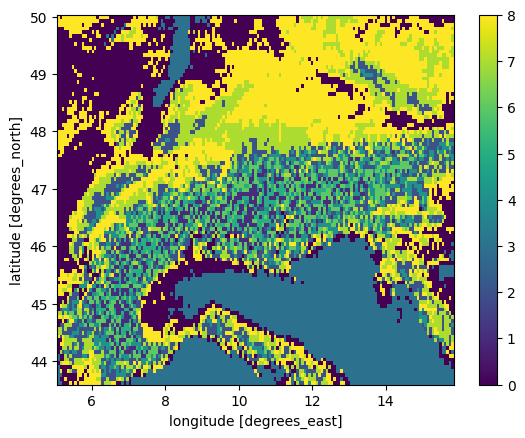

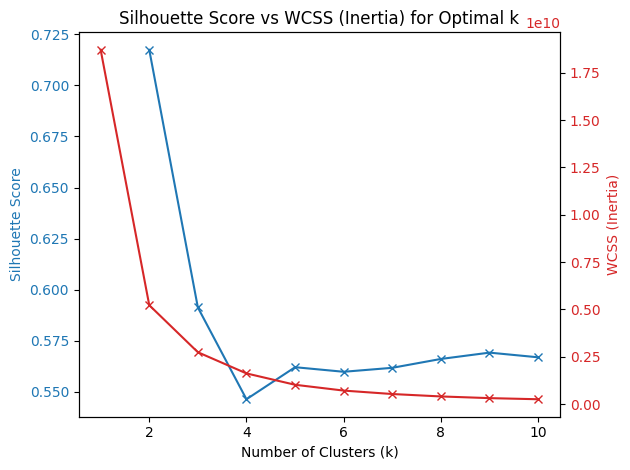

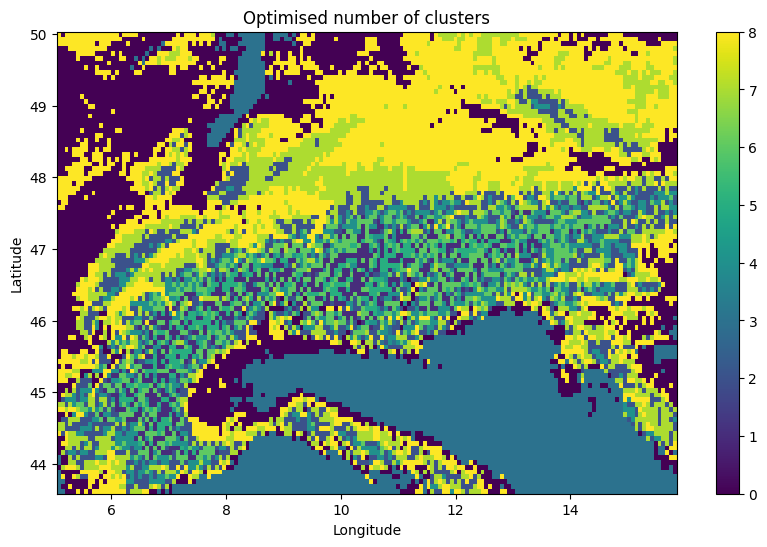

In [3]:
if __name__ == '__main__':

    client = Client()

    # initialize timing
    start_time = time.monotonic()
        
    # initialize network filename
    state_file = NAMING_Model.state_file(
        NET, PREDICTAND, ERA5_PREDICTORS, ERA5_PLEVELS, WET_DAY_THRESHOLD, dem=DEM,
        dem_features=DEM_FEATURES, doy=DOY, stratify=STRATIFY)
    
    state_file = MODEL_PATH.joinpath(PREDICTAND, state_file)
    target = TARGET_PATH.joinpath(PREDICTAND)

    # check if output path exists
    if not target.exists():
        target.mkdir(parents=True, exist_ok=True)
    # initialize logging
    log_file = state_file.with_name(state_file.name + "_log.txt")
    
    if log_file.exists():
        log_file.unlink()
    dictConfig(log_conf(log_file))

    # check if target dataset already exists
    target = target.joinpath(state_file.name + '.nc')
    if target.exists() and not OVERWRITE:
        LogConfig.init_log('{} already exists.'.format(target))
        sys.exit()

    LogConfig.init_log('Initializing downscaling for period: {}'.format(
        ' - '.join([str(CALIB_PERIOD[0]), str(CALIB_PERIOD[-1])])))

    # initialize ERA5 predictor dataset
    LogConfig.init_log('Initializing ERA5 predictors.')
    Era5 = ERA5Dataset(ERA5_PATH.joinpath('ERA5'), ERA5_PREDICTORS,
                       plevels=ERA5_PLEVELS)
    Era5_ds = Era5.merge(chunks=CHUNKS)
    Era5_ds = Era5_ds.rename({'lon': 'x','lat': 'y'})
    
    # initialize OBS predictand dataset
    LogConfig.init_log('Initializing observations for predictand: {}'
                       .format(PREDICTAND))

    # read in-situ gridded observations
    Obs_ds = search_files(OBS_PATH.joinpath(PREDICTAND), '.nc$').pop()
    Obs_ds = xr.open_dataset(Obs_ds)
    Obs_ds = Obs_ds.rename({'lon': 'x','lat': 'y'})

    # whether to use digital elevation model
    if DEM:
        # digital elevation model: Copernicus EU-Dem v1.1
        dem = search_files(DEM_PATH, '^interTwin_dem.nc$').pop()

        # read elevation and compute slope and aspect
        dem = ERA5Dataset.dem_features(
            dem, {'y': Era5_ds.y, 'x': Era5_ds.x},
            add_coord={'time': Era5_ds.time})

        # check whether to use slope and aspect
        if not DEM_FEATURES:
            dem = dem.drop_vars(['slope', 'aspect']).chunk(Era5_ds.chunks)

        # add dem to set of predictor variables
        dem = dem.chunk(Era5_ds.chunks)
        Era5_ds = xr.merge([Era5_ds, dem])


    # initialize training data
    LogConfig.init_log('Initializing training data.')

    # split calibration period into training and validation period
    if PREDICTAND == 'pr' and STRATIFY:
        # stratify training and validation dataset by number of
        # observed wet days for precipitation
        wet_days = (Obs_ds.sel(time=CALIB_PERIOD).mean(dim=('y', 'x'))
                    >= WET_DAY_THRESHOLD).to_array().values.squeeze()
        train, valid = train_test_split(
            CALIB_PERIOD, stratify=wet_days, test_size=VALID_SIZE)

        # sort chronologically
        train, valid = sorted(train), sorted(valid)
        Era5_train, Obs_train = Era5_ds.sel(time=train), Obs_ds.sel(time=train)
        Era5_valid, Obs_valid = Era5_ds.sel(time=valid), Obs_ds.sel(time=valid)
    else:
        LogConfig.init_log('We are not calculating Stratified Precipitation based on Wet Days here!')

    # training and validation dataset
    Era5_train, Obs_train = Era5_ds.sel(time=CALIB_PERIOD), Obs_ds.sel(time=CALIB_PERIOD)
    Era5_valid, Obs_valid = Era5_ds.sel(time=VALID_PERIOD), Obs_ds.sel(time=VALID_PERIOD)

    # whether to use digital elevation model
    if DEM:
        # digital elevation model: Copernicus EU-Dem v1.1
        dem = search_files(DEM_PATH, '^interTwin_dem.nc$').pop()

        # read elevation and compute slope and aspect
        dem = ERA5Dataset.dem_features(
            dem, {'y': Obs_train.y, 'x': Obs_train.x},
            add_coord={'time': Obs_train.time})

        # check whether to use slope and aspect
        if not DEM_FEATURES:
            dem = dem.drop_vars(['slope', 'aspect']).chunk(Obs_train.chunks)

        # add dem to set of predictor variables
        dem = dem.chunk(Obs_train.chunks)
        Obs_train = xr.merge([Obs_train, dem])

    #statistics_dataset = calculate_statistics_to_dataset(Obs_train)
    LogConfig.init_log(f'To see : {Obs_train}')

    statistics_dataset = compute_summary_stats(Obs_train)

    LogConfig.init_log(f'Summary statistics loaded along the time dimension : {statistics_dataset}')

    lat_lon_flat = statistics_dataset.to_array().stack(points=('y', 'x')).T.values

    clustered_map = full_clustering_workflow(statistics_dataset, lat_lon_flat)
    plot_silhouette_vs_wcss(lat_lon_flat, max_k=10)
    plot_data_array(clustered_map, title='Optimised number of clusters')

    LogConfig.init_log(f'Clustered map dataset here : {clustered_map}')


    Era5_train = doy_encoding(Era5_train, Obs_train, doy=DOY)
    Era5_valid = doy_encoding(Era5_valid, Obs_valid, doy=DOY)
    
    predictors_train = stacker(Era5_train).compute()
    predictors_valid = stacker(Era5_valid).compute()
    predictand_train = stacker(Obs_train.drop_vars("elevation"))
    predictand_valid = stacker(Obs_valid)

    cluster_py = clustered_map.stack(spatial=('y', 'x')).to_numpy()
    cluster_dict = {}
    
    # Get unique values from the data array
    unique_values = np.unique(cluster_py)  # Use `.values` to get the raw NumPy array
    
    # Loop through each unique value and capture the indices
    for value in unique_values:
        # Get the indices where the value occurs in the DataArray using NumPy
        indices = np.argwhere(cluster_py == value)
        
        # Convert to list of tuples (x, y) and store in the dictionary
        cluster_dict[value] = indices.squeeze()
    
        LogConfig.init_log(f'Clusters and their shapes: {cluster_dict[value].shape}')



In [4]:
lgb_models = joblib.load('trained_lgb_models_gpu_complete_nT50_test.pkl')


In [5]:
lgb_models

{0: <lightgbm.basic.Booster at 0x7e3c225cbed0>,
 1: <lightgbm.basic.Booster at 0x7e3cfa764290>,
 2: <lightgbm.basic.Booster at 0x7e3c1b5b60d0>,
 3: <lightgbm.basic.Booster at 0x7e3bd98c4cd0>,
 4: <lightgbm.basic.Booster at 0x7e3c55eec750>,
 5: <lightgbm.basic.Booster at 0x7e3be8f93910>,
 6: <lightgbm.basic.Booster at 0x7e3bbb65bad0>,
 7: <lightgbm.basic.Booster at 0x7e3bcc7c4350>,
 8: <lightgbm.basic.Booster at 0x7e3bf4a774d0>}

In [6]:
predictand_valid.shape

(15456, 366, 1)

In [7]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


prediction = np.ones(shape=(predictand_valid.shape[1], predictand_valid.shape[0], 1)) * np.nan

# Iterate through clusters and process in batches
for cluster_id, indices in cluster_dict.items():
    LogConfig.init_log(f"Processing cluster {cluster_id} with {len(indices)} indices")
        
    # Extract the data for the current batch from the numpy array
    X_unseen = predictors_valid[indices, :, :]  # shape: (batch_size, 1826, 15)

    truth = predictand_valid[indices, :, 0]

    LogConfig.init_log(X_unseen.shape, truth.shape)
    
    X = X_unseen.reshape(-1, 15)  # shape: (batch_size * 1826, 15)
    y = truth.flatten()

    LogConfig.init_log(X.shape, y.shape)

    # Make predictions using the trained model for the current cluster
    if cluster_id in lgb_models:
        preds = lgb_models[cluster_id].predict(X)
        LogConfig.init_log('Cluster ID: {:d} - score: R2: {:.2f}, MSE: {:.2f}, MAE: {:.2f}'.format(cluster_id, r2_score(y, preds), mean_squared_error(y, preds), mean_absolute_error(y, preds)))

         # Reshape the predictions and ground truth back to (batch_size, 1826)
        preds_unflattened = preds.reshape(len(indices), truth.shape[1])

        prediction[:, indices, 0] = preds_unflattened.T
        
    else:
        LogConfig.init_log(f"No trained model found for cluster {cluster_id}")

    LogConfig.init_log(f"Model for cluster {cluster_id} trained and stored.")
    
        # Example: Run your regression model with `flattened_batch_data`
        # regression_model.fit(flattened_batch_data, target)
prediction = prediction.reshape(Obs_valid.time.shape[0],Obs_valid.y.shape[0], Obs_valid.x.shape[0], 1).squeeze()

# store predictions in xarray.Dataset
predictions = xr.DataArray(data=prediction, dims=['time', 'y', 'x'], coords=dict(time=pd.date_range(Era5_valid.time.values[0],Era5_valid.time.values[-1], freq='D'), lat=Obs_valid.y, lon=Obs_valid.x))
predictions = predictions.to_dataset(name=PREDICTAND)

predictions = predictions.set_index(
    time='time',
    y='lat',
    x='lon'
)

predictions.to_netcdf("/home/sdhinakaran/eurac/downScaleML-refactoring/downscaleml/main/CLUSTERED_50T_tasmean_2016_downscaled_LGBM_GPU.nc")

LogConfig.init_log('Prediction Saved!!! SMILE PLEASE')

Processing cluster 0 with 3027 indices
(3027, 366, 15) (3027, 366)
(1107882, 15) (1107882,)


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T16:05:28: Cluster ID: 0 - score: R2: 0.99, MSE: 0.79, MAE: 0.66
downscaleml.core.utils: --------------------------------------------------------------------------------


Model for cluster 0 trained and stored.
Processing cluster 1 with 566 indices
(566, 366, 15) (566, 366)
(207156, 15) (207156,)


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T16:05:35: Cluster ID: 1 - score: R2: 0.96, MSE: 2.29, MAE: 1.16
downscaleml.core.utils: --------------------------------------------------------------------------------


Model for cluster 1 trained and stored.
Processing cluster 2 with 1304 indices
(1304, 366, 15) (1304, 366)
(477264, 15) (477264,)


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T16:05:43: Cluster ID: 2 - score: R2: 0.97, MSE: 1.42, MAE: 0.91
downscaleml.core.utils: --------------------------------------------------------------------------------


Model for cluster 2 trained and stored.
Processing cluster 3 with 2786 indices
(2786, 366, 15) (2786, 366)
(1019676, 15) (1019676,)


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T16:05:59: Cluster ID: 3 - score: R2: 0.98, MSE: 0.85, MAE: 0.69
downscaleml.core.utils: --------------------------------------------------------------------------------


Model for cluster 3 trained and stored.
Processing cluster 4 with 942 indices
(942, 366, 15) (942, 366)
(344772, 15) (344772,)


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T16:06:05: Cluster ID: 4 - score: R2: 0.96, MSE: 1.92, MAE: 1.07
downscaleml.core.utils: --------------------------------------------------------------------------------


Model for cluster 4 trained and stored.
Processing cluster 5 with 292 indices
(292, 366, 15) (292, 366)
(106872, 15) (106872,)


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T16:06:10: Cluster ID: 5 - score: R2: 0.97, MSE: 1.56, MAE: 0.91
downscaleml.core.utils: --------------------------------------------------------------------------------


Model for cluster 5 trained and stored.
Processing cluster 6 with 822 indices
(822, 366, 15) (822, 366)
(300852, 15) (300852,)


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T16:06:20: Cluster ID: 6 - score: R2: 0.97, MSE: 1.71, MAE: 1.00
downscaleml.core.utils: --------------------------------------------------------------------------------


Model for cluster 6 trained and stored.
Processing cluster 7 with 2071 indices
(2071, 366, 15) (2071, 366)
(757986, 15) (757986,)


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T16:06:39: Cluster ID: 7 - score: R2: 0.98, MSE: 1.03, MAE: 0.77
downscaleml.core.utils: --------------------------------------------------------------------------------


Model for cluster 7 trained and stored.
Processing cluster 8 with 3646 indices
(3646, 366, 15) (3646, 366)
(1334436, 15) (1334436,)


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-11-07T16:07:25: Cluster ID: 8 - score: R2: 0.99, MSE: 0.76, MAE: 0.65
downscaleml.core.utils: --------------------------------------------------------------------------------


Model for cluster 8 trained and stored.


(366, 15456, 1)

In [22]:
unstacked.shape

(366, 96, 161)

In [23]:
prediction.shape

(366, 15456, 1)

In [33]:
prediction = prediction.reshape(Obs_valid.time.shape[0],Obs_valid.y.shape[0], Obs_valid.x.shape[0], 1).squeeze()

In [34]:
idea.shape

(366, 96, 161)